# Tables I want

Initial summary table

3 level titles
Biography
Wealth analysis
Philanthropy
Political Interests
Known Associates
Service Providers
Family Details

2nd level titles


## Not included

Significant Litigation: This has a more complex structure. I could get the counts of people with significant litigation and see if it is worht extracting

In [2]:
no_title_tables = {'career_history_2':['Company', 'Type', 'Position Held', 'YearStarted', 'YearEnded',
       'Remarks'],
       'philanthropy_2':['giving_profile'],
       'political_interests_2':['Political Profile'],
       'known_associates_2':['Name', 'Company', 'Relationships', 'Remarks'],
       'service_providers_2':['Name', 'Company', 'Position', 'Remarks'],
       'family_details_2':['Relation', 'Name', 'Age', 'Remarks']
       }

no_title_tables

{'career_history_2': ['Company',
  'Type',
  'Position Held',
  'YearStarted',
  'YearEnded',
  'Remarks'],
 'philanthropy_2': ['giving_profile'],
 'political_interests_2': ['Political Profile'],
 'known_associates_2': ['Name', 'Company', 'Relationships', 'Remarks'],
 'service_providers_2': ['Name', 'Company', 'Position', 'Remarks'],
 'family_details_2': ['Relation', 'Name', 'Age', 'Remarks']}

In [3]:
import pdfplumber
import re
import pandas as pd
import re
from collections import defaultdict
from wealthnet_helpers import *

In [6]:
city_path = './data/cleaned_cities/London'
file_path = 'Wealth-X Andrey Vagnerovich Andreev Dossier.pdf'
file_path =  city_path+ '/' + file_path  #"./data/london/Wealth-X Ahti Pentti Vilppula Dossier.pdf"
search_text = "Biography"


pdf = pdfplumber.open(file_path )

page_number = 3
page = pdf.pages[page_number]


table_settings={
"vertical_strategy": "lines",
"horizontal_strategy": "lines",
"explicit_vertical_lines": page.curves, # used for extract table from page[0]
"explicit_horizontal_lines": page.curves # used for extract table from page[0]
}


table = page.extract_tables(table_settings)

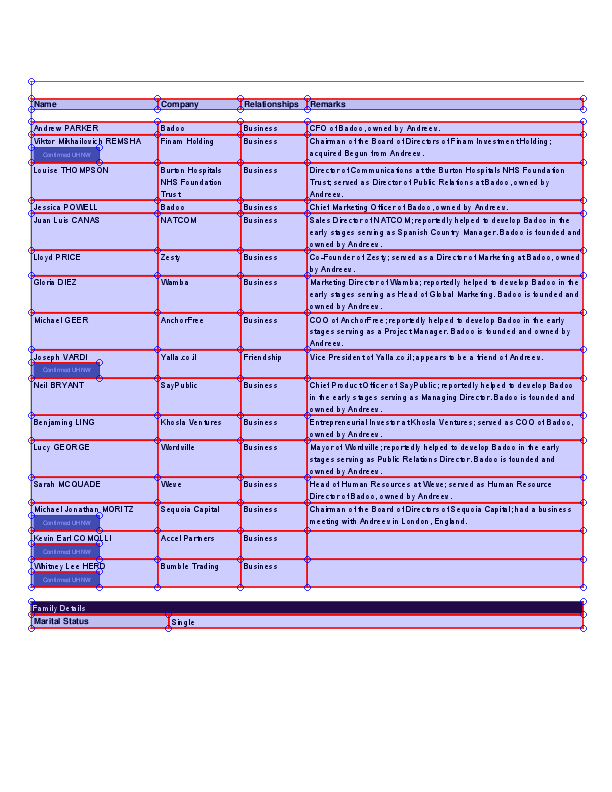

In [7]:
#table_settings={"vertical_strategy": "text", 
#                "horizontal_strategy": "text"}


im = page.to_image()
im.debug_tablefinder(table_settings)



In [11]:
table[1]

[['Andrew PARKER', 'Badoo', 'Business', 'CFO of Badoo, owned by Andreev.'],
 ['Viktor Mikhailovich REMSHA\nConfirmed UHNW',
  'Finam Holding',
  'Business',
  'Chairman of the Board of Directors of Finam Investment Holding;\nacquired Begun from Andreev.'],
 ['Confirmed UHNW', None, None, None],
 ['Louise THOMPSON',
  'Burton Hospitals\nNHS Foundation\nTrust',
  'Business',
  'Director of Communications at the Burton Hospitals NHS Foundation\nTrust; served as Director of Public Relations at Badoo, owned by\nAndreev.'],
 ['Jessica POWELL',
  'Badoo',
  'Business',
  'Chief Marketing Officer of Badoo, owned by Andreev.'],
 ['Juan Luis CANAS',
  'NATCOM',
  'Business',
  'Sales Director of NATCOM; reportedly helped to develop Badoo in the\nearly stages serving as Spanish Country Manager. Badoo is founded and\nowned by Andreev.'],
 ['Lloyd PRICE',
  'Zesty',
  'Business',
  'Co-Founder of Zesty; served as a Director of Marketing at Badoo, owned\nby Andreev.'],
 ['Gloria DIEZ',
  'Wamba',
  

In [13]:
no_title_tables

{'career_history_2': ['Company',
  'Type',
  'Position Held',
  'YearStarted',
  'YearEnded',
  'Remarks'],
 'philanthropy_2': ['giving_profile'],
 'political_interests_2': ['Political Profile'],
 'known_associates_2': ['Name', 'Company', 'Relationships', 'Remarks'],
 'service_providers_2': ['Name', 'Company', 'Position', 'Remarks'],
 'family_details_2': ['Relation', 'Name', 'Age', 'Remarks']}

In [32]:
def extract_all_tables(pdf, table2df_params, no_title_tables, verbose = False):

    totalpages = len(pdf.pages)

    tables_dict = {}
    out = None
    table_id = None

    for page_number in range(1, totalpages):

        page = pdf.pages[page_number]

        table_settings={
            "vertical_strategy": "lines",
            "horizontal_strategy": "lines",
            "explicit_vertical_lines": page.curves, # used for extract table from page[0]
            "explicit_horizontal_lines": page.curves # used for extract table from page[0]
            }

        table = page.extract_tables(table_settings)
        #removes the \n newline symbold from the text
        table = recursively_apply(table, replace_chars)
        
        if verbose:
            print("page number "+str(page_number)+" number of tables: " +str(len(table)))

        for n in range(0, len(table)):
            table_temp =table[n]
            #print(f"Table Temp (n={n}): {table_temp}")
            if verbose:
                print(table_temp[0][0])
            
            #there may be occaisions when the table is empty for example no known family
            if table_temp and len(table_temp[0]) > 0:
                #This kicks in if there is a table with one of the main headers
                sub_table = table2df_params.loc[[x == table_temp[0][0] for x in table2df_params['table_name']],:].reset_index(drop=True)
            
                #check if the table is one of the named tables
                if (sub_table.shape[0]==1):
                    #If the named table has no rows the next section is ignored
                    if sub_table['column_names'][0] < len(table_temp):
                        table_id = sub_table['table_id'].to_string(index = False)
                        column_names = rename_none_in_list(table_temp[sub_table['column_names'][0]])
                        out = pd.DataFrame(table_temp[sub_table['data_start'][0]:], columns = column_names)
                #otherwise check if table is one of the named tables but the title is on the previous page
                else:
                    #cycle through each set of column headers and check to see if they match
                    for key, value in no_title_tables.items():#range(0, len(no_title_tables )):
                        result = set(value).issubset(table_temp[0])
                        #if they do match extract the table
                        if result:
                            out = out = pd.DataFrame(table_temp[1:], columns=table_temp[0])
                            table_id = key

                        else: None



            if out is not None:
                if verbose:
                    print(table_id)
                    
                tables_dict[table_id] = out
                out = None
                table_id = None
    return tables_dict


In [33]:
file_path = "./data/london/Wealth-X Alan Eldad Howard Dossier.pdf"

table2df_params = pd.DataFrame({'table_name':['Family Details', 'Biography','Career History', 
                                              'Wealth Analysis', 'Clubs & Boards', 'Known Associates', 'Service Providers', 'Philanthropy'],
'table_id':['family_details', 'biograhy','career_history', 
                                              'wealth_analysis', 'clubs_and_boards', 'known_associates', 'service_providers', 'philanthropy'],
'data_start':[3,1,2,2,2,2,2,1],
'column_names':[2,0,1,1,1,1,1,0]})


pdf = pdfplumber.open(file_path )

tables_dict = extract_all_tables(pdf, table2df_params, no_title_tables)

tables_dict['summary'] = extract_summary_data(pdf)

tables_dict = combine_dataframes_with_suffix(tables_dict)

sub_table['column_names'][0]:  0
Length of table_temp:  2
sub_table['column_names'][0]:  1
Length of table_temp:  9
sub_table['column_names'][0]:  1
Length of table_temp:  2
sub_table['column_names'][0]:  1
Length of table_temp:  8
sub_table['column_names'][0]:  0
Length of table_temp:  2
sub_table['column_names'][0]:  1
Length of table_temp:  11
sub_table['column_names'][0]:  1
Length of table_temp:  3
defaultdict(<class 'list'>, {'biograhy': ['biograhy'], 'career_history': ['career_history'], 'wealth_analysis': ['wealth_analysis'], 'clubs_and_boards': ['clubs_and_boards'], 'philanthropy': ['philanthropy'], 'known_associates': ['known_associates', 'known_associates_2'], 'service_providers': ['service_providers'], 'summary': ['summary']})


In [15]:
tables_dict 

{'biograhy':                                            Biography
 0  Late uncle, Hayel Saeed Anam, together with hi...,
 'career_history':                               Company             Type  Position Held  \
 0                    Sunrays Bakeries  Private Company       Director   
 1                     Longulf Trading  Private Company       Director   
 2         Middle East Trading Company  Private Company       Director   
 3                     Alsaeed Trading  Private Company       Director   
 4         National Products Marketing  Private Company       Director   
 5    United Insurance Company (Yemen)  Private Company  Vice Chairman   
 6  Hayel Saeed Anam Group (HSA Group)  Private Company         Member   
 
   YearStarted YearEnded                                            Remarks  
 0        1992      1995  London, United Kingdom-based company establish...  
 1        1992      1996  London, United Kingdom-based company specializ...  
 2                        Subsidi

given the text string

"bango bango hometown london age 37 married no residences london, paris, new york favourite cheese chedder bio"

reformat it using a python function into a dataframe such that the key expressions listed below form a list 

- person
- hometown
- age
- married
- residences
- favourite cheese
- bio

the initial text is thus reformated into a dataframe such that the data looks like the python dictionary below

{'person':'bango bango',
'hometown':'london',
'age':'37',
'married':'no',
'residences':'london, paris, new york',
'favourite cheese':'chedder'}

In [12]:

# Extract summary data on individual
text_json = pdf.pages[1].extract_text()
text = text_json.replace("\n", " ")
print(text)
keys = ['Name', 'Primary Position', 'Source', 'Primary Company', 'Age', 
        'Estimated Net Worth', 'Birthday', 'Estimated Liquid Assets', 'Marital Status', 'Estimated Household Wealth', 
        'Religion', 'Estimated Household Liquid', 'Alternate Names', "Estimated Family's Net Worth", "Estimated Family's Liquid",
        "Assets", "Wealth Trend", "Residences", "Hometown"]

df = text_to_dataframe(text, keys)
df

Abdullah Abdo Saeed ANAM Primary Position Member Source Self-Made Primary Company Hayel Saeed Anam Group (HSA Age 74 Group) Estimated Net Worth At least $640 million Birthday Jan 1945 Estimated Liquid Assets At least $280 million Marital Status Unknown Estimated Household Wealth - Religion Estimated Household Liquid Alternate Names Abdullah Abdo Assets Saeed Estimated Family's Net Worth At least $1.8 billion Estimated Family's Liquid At least $760 million Assets Wealth Trend Majority of fortune fluctuates with the performance of Hayel Saeed Anam Group; remainder fluctuates with the broad equity and bond markets. Wealth estimate does not reflect entire family fortune and is subject to undisclosed stake ownership in Hayel Saeed Anam Group. Residences Ta'izz, Yemen London, Greater London, United Kingdom Sana'a, Sana'a, Yemen Hometown Ta'izz, Yemen Biography Late uncle, Hayel Saeed Anam, together with his brothers, Mohammed, Gazem, and Abdo, co-founded what is currently known as Hayel Saee

,Name,Primary Position,Source,Primary Company,Age,Estimated Net Worth,Birthday,Estimated Liquid Assets,Marital Status,Estimated Household Wealth,Alternate Names,Estimated Family's Net Worth,Estimated Family's Liquid,Assets,Wealth Trend,Residences,Hometown
0,Abdullah Abdo Saeed ANAM,Member,Self-Made,Hayel Saeed Anam Group (HSA,74 Group),At least $640 million,Jan 1945,At least $280 million,Unknown,-,Abdullah Abdo Assets Saeed,At least $1.8 billion,At least $760 million,At least $280 million Marital Status Unknown E...,Majority of fortune fluctuates with the perfor...,"Ta'izz, Yemen London, Greater London, United K...","Ta'izz, Yemen Biography Late uncle, Hayel Saee..."
